## Introduction

This is the first of a series of tutorials on the universal probabilistic programming language **Turing**.

Turing is a probabilistic programming system written entirely in Julia.
It has an intuitive modelling syntax and supports a wide range of sampling-based inference algorithms.

Familiarity with Julia is assumed throughout this tutorial.
If you are new to Julia, [Learning Julia](https://julialang.org/learning/) is a good starting point.

For users new to Bayesian machine learning, please consider more thorough introductions to the field such as [Pattern Recognition and Machine Learning](https://www.springer.com/us/book/9780387310732).
This tutorial tries to provide an intuition for Bayesian inference and gives a simple example on how to use Turing.
Note that this is not a comprehensive introduction to Bayesian machine learning.

### Coin Flipping Without Turing

The following example illustrates the effect of updating our beliefs with every piece of new evidence we observe.

Assume that we are unsure about the probability of heads in a coin flip.
To get an intuitive understanding of what "updating our beliefs" is, we will visualize the probability of heads in a coin flip after each observed evidence.

First, let us load some packages that we need to simulate a coin flip

In [1]:
using Distributions

using Random
Random.seed!(12); # Set seed for reproducibility

and to visualize our results.

In [2]:
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1664


Note that Turing is not loaded here — we do not use it in this example.
If you are already familiar with posterior updates, you can proceed to the next step.

Next, we configure the data generating model.
Let us set the true probability that a coin flip turns up heads

In [3]:
p_true = 0.5;

and set the number of coin flips we will show our model.

In [4]:
N = 100;

We simulate `N` coin flips by drawing `N` random samples from the Bernoulli distribution with success probability `p_true`.
The draws are collected in a variable called `data`:

In [5]:
data = rand(Bernoulli(p_true), N);

Here is what the first five coin flips look like:

In [6]:
data[1:5]

5-element Vector{Bool}:
 1
 0
 0
 0
 1

Next, we specify a prior belief about the distribution of heads and tails in a coin toss.
Here we choose a [Beta](https://en.wikipedia.org/wiki/Beta_distribution) distribution as prior distribution for the probability of heads.
Before any coin flip is observed, we assume a uniform distribution $\operatorname{U}(0, 1) = \operatorname{Beta}(1, 1)$ of the probability of heads.
I.e., every probability is equally likely initially.

In [7]:
prior_belief = Beta(1, 1);

With our priors set and our data at hand, we can perform Bayesian inference.

This is a fairly simple process.
We expose one additional coin flip to our model every iteration, such that the first run only sees the first coin flip, while the last iteration sees all the coin flips.
In each iteration we update our belief to an updated version of the original Beta distribution that accounts for the new proportion of heads and tails.
The update is particularly simple since our prior distribution is a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior).
Note that a closed-form expression for the posterior (implemented in the `updated_belief` expression below) is not accessible in general and usually does not exist for more interesting models.

┌ Info: Saved animation to c:\Users\olarinoyem\Desktop\fun\notebook\00-introduction\tmp.gif
└ @ Plots C:\Users\olarinoyem\.julia\packages\Plots\jqILG\src\animation.jl:149


Plots.AnimatedGif("c:\\Users\\olarinoyem\\Desktop\\fun\\notebook\\00-introduction\\tmp.gif")
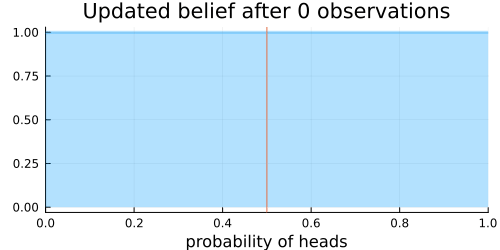

In [8]:
function updated_belief(prior_belief::Beta, data::AbstractArray{Bool})
    # Count the number of heads and tails.
    heads = sum(data)
    tails = length(data) - heads

    # Update our prior belief in closed form (this is possible because we use a conjugate prior).
    return Beta(prior_belief.α + heads, prior_belief.β + tails)
end

# Show updated belief for increasing number of observations
@gif for n in 0:N
    plot(
        updated_belief(prior_belief, data[1:n]);
        size=(500, 250),
        title="Updated belief after $n observations",
        xlabel="probability of heads",
        ylabel="",
        legend=nothing,
        xlim=(0, 1),
        fill=0,
        α=0.3,
        w=3,
    )
    vline!([p_true])
end

The animation above shows that with increasing evidence our belief about the probability of heads in a coin flip slowly adjusts towards the true value.
The orange line in the animation represents the true probability of seeing heads on a single coin flip, while the mode of the distribution shows what the model believes the probability of a heads is given the evidence it has seen.

For the mathematically inclined, the $\operatorname{Beta}$ distribution is updated by adding each coin flip to the parameters $\alpha$ and $\beta$ of the distribution.
Initially, the parameters are defined as $\alpha = 1$ and $\beta = 1$.
Over time, with more and more coin flips, $\alpha$ and $\beta$ will be approximately equal to each other as we are equally likely to flip a heads or a tails.

The mean of the $\operatorname{Beta}(\alpha, \beta)$ distribution is

$$\operatorname{E}[X] = \dfrac{\alpha}{\alpha+\beta}.$$

This implies that the plot of the distribution will become centered around 0.5 for a large enough number of coin flips, as we expect $\alpha \approx \beta$.

The variance of the $\operatorname{Beta}(\alpha, \beta)$ distribution is

$$\operatorname{var}[X] = \dfrac{\alpha\beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}.$$

Thus the variance of the distribution will approach 0 with more and more samples, as the denominator will grow faster than will the numerator.
More samples means less variance.
This implies that the distribution will reflect less uncertainty about the probability of receiving a heads and the plot will become more tightly centered around 0.5 for a large enough number of coin flips.

### Coin Flipping With Turing

We now move away from the closed-form expression above.
We use **Turing** to specify the same model and to approximate the posterior distribution with samples.
To do so, we first need to load `Turing`.

In [10]:
using Turing

LoadError: ArgumentError: Package Turing not found in current path.
- Run `import Pkg; Pkg.add("Turing")` to install the Turing package.

Additionally, we load `MCMCChains`, a library for analyzing and visualizing the samples with which we approximate the posterior distribution.

In [ ]:
using MCMCChains

First, we define the coin-flip model using Turing.

In [ ]:
# Unconditioned coinflip model with `N` observations.
@model function coinflip(; N::Int)
    # Our prior belief about the probability of heads in a coin toss.
    p ~ Beta(1, 1)

    # Heads or tails of a coin are drawn from `N` independent and identically
    # distributed Bernoulli distributions with success rate `p`.
    y ~ filldist(Bernoulli(p), N)

    return y
end;

In the Turing model the prior distribution of the variable `p`, the probability of heads in a coin toss, and the distribution of the observations `y` are specified on the right-hand side of the `~` expressions.
The `@model` macro modifies the body of the Julia function `coinflip` and, e.g., replaces the `~` statements with internal function calls that are used for sampling.

Here we defined a model that is not conditioned on any specific observations as this allows us to easily obtain samples of both `p` and `y` with

In [ ]:
rand(coinflip(; N))

The model can be conditioned on some observations with `|`.
See the [documentation of the `condition` syntax](https://turinglang.github.io/DynamicPPL.jl/stable/api/#Condition-and-decondition) in DynamicPPL.jl for more details.
In the conditioned `model` the observations `y` are fixed to `data`.

In [ ]:
coinflip(y::AbstractVector{<:Real}) = coinflip(; N=length(y)) | (; y)

model = coinflip(data);

After defining the model, we can approximate the posterior distribution by drawing samples from the distribution.
In this example, we use a [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) sampler to draw these samples.
Other tutorials give more information on the samplers available in Turing and discuss their use for different models.

In [ ]:
sampler = NUTS();

We approximate the posterior distribution with 1000 samples:

In [ ]:
chain = sample(model, sampler, 1_000; progress=false);

The `sample` function and common keyword arguments are explained more extensively in the documentation of [AbstractMCMC.jl](https://turinglang.github.io/AbstractMCMC.jl/dev/api/).

After finishing the sampling process, we can visually compare the closed-form posterior distribution with the approximation obtained with Turing.

In [ ]:
histogram(chain)

Now we can build our plot:

In [ ]:
@assert isapprox(mean(chain, :p), 0.5; atol=0.1)

In [ ]:
# Visualize a blue density plot of the approximate posterior distribution using HMC (see Chain 1 in the legend).
density(chain; xlim=(0, 1), legend=:best, w=2, c=:blue)

# Visualize a green density plot of the posterior distribution in closed-form.
plot!(
    0:0.01:1,
    pdf.(updated_belief(prior_belief, data), 0:0.01:1);
    xlabel="probability of heads",
    ylabel="",
    title="",
    xlim=(0, 1),
    label="Closed-form",
    fill=0,
    α=0.3,
    w=3,
    c=:lightgreen,
)

# Visualize the true probability of heads in red.
vline!([p_true]; label="True probability", c=:red)

As we can see, the samples obtained with Turing closely approximate the true posterior distribution.
Hopefully this tutorial has provided an easy-to-follow, yet informative introduction to Turing's simpler applications.
More advanced usage is demonstrated in other tutorials.

In [ ]:
isdefined(Main, :TuringTutorials) &&
    Main.TuringTutorials.tutorial_footer(WEAVE_ARGS[:folder], WEAVE_ARGS[:file])